<a href="https://colab.research.google.com/github/Omdena-Bhutan/introductory-assignment-Jeewan0406/blob/main/Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyyaml


In [ ]:
import os
import yaml
import shutil
import logging
import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from dataclasses import dataclass
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [ ]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

file_handler = logging.FileHandler('app.log')
file_handler.setFormatter(formatter)

logger.addHandler(file_handler)

def download_kaggle_data()-> Path:
  """
  Downloading data from kaggle and store in colab

  Returns:
    Path: Path to the downloaded dataset

  Raises:
    FileNotFoundError: If the file is not found
    Exception: If any other error occurs
  """
  try:
    path = kagglehub.dataset_download("zafarali27/house-price-prediction-dataset")
    print("Path to dataset files:", path)
    logger.info(f"Path to dataset files: {path}")
    return path

  except FileNotFoundError:
    logger.error(f"File not found at {path}")
    raise

  except Exception as e:
    logging.error(e)
    raise e



In [ ]:
# Copy data to new directory
def copy_data_to_new_directory()-> Path:
  """
  Moving data downloaded form kaggle, from root cache directory to newly created directory

  Returns:
    Path: Path to the new directory

  Raises:
    FileNotFoundError: If the file is not found
    Exception: If any other error occurs
  """
  new_dataset_dir = Path("Dataset")
  os.makedirs(new_dataset_dir, exist_ok=True)

  data_path = download_kaggle_data()

  try:
    shutil.copytree(str(data_path), str(new_dataset_dir), dirs_exist_ok=True)
    logging.info(f"Data copied to {new_dataset_dir}")
    return new_dataset_dir

  except FileNotFoundError:
    logging.error(f"File not found at source: {data_path} or destination: {new_dataset_dir}")
    raise

  except Exception as e:
    logging.error(e)
    raise e

copy_data_to_new_directory()

100%|██████████| 28.7k/28.7k [00:00<00:00, 32.4MB/s]

Extracting files...



INFO:__main__:Path to dataset files: /root/.cache/kagglehub/datasets/zafarali27/house-price-prediction-dataset/versions/1


Path to dataset files: /root/.cache/kagglehub/datasets/zafarali27/house-price-prediction-dataset/versions/1


PosixPath('Dataset')

In [ ]:
def write_to_yaml()->None:

  """
  Write parameters to yaml file

  Raises:
    OSError: If the file cannot be written.
    yaml.YAMLError: If serialization fails.
  """
  try:
    params = {
      "data": {
          "data_url": "/content/Dataset/House Price Prediction Dataset.csv",
          "batch_size": 32
      },
      "model": {
          "name": "linear regression",
          "learning_rate": 0.01
      },
      "training": {
          "epochs": 30,
          "early_stopping": True
      }
  }

  except OSError as e:
    logger.error(f"Error writing to YAML file: {e}")
    raise
  except yaml.YAMLError as e:
    logger.error(f"YAML serialization error: {e}")
    raise

  with open("params.yaml", "w") as f:
    yaml.safe_dump(
        params,
        f,
        sort_keys=False
    )
write_to_yaml()

In [ ]:
def load_dataset(path: Path)-> pd.DataFrame:
  """
  Opening DataFrame using params.yaml fle

  Args:
    path (Path): Path to the dataset

  Returns:
    pd.DataFrame: DataFrame containing the dataset

  Raises:
    FileNotFoundError: If the file is not found
    Exception: If any other error occurs
  """
  if not os.path.exists(path):
    raise FileNotFoundError(f"File not found at {path}")

  try:
    with open(path, "r") as f:
      params = yaml.safe_load(f)
      # Corrected: Read the CSV from the data_url specified in params.yaml
      df = pd.read_csv(params['data']['data_url'])
      logger.info(f"Data loaded from {params['data']['data_url']}")
      return df


  except FileNotFoundError:
    logger.error(f"File not found at {path}")
    raise

  except Exception as e:
    logger.error(e)
    raise e

df = load_dataset("params.yaml")
df.head()

,Id,Area,Bedrooms,Bathrooms,Floors,YearBuilt,Location,Condition,Garage,Price
0,1,1360,5,4,3,1970,Downtown,Excellent,No,149919
1,2,4272,5,4,3,1958,Downtown,Excellent,No,424998
2,3,3592,2,2,3,1938,Downtown,Good,No,266746
3,4,966,4,2,2,1902,Suburban,Fair,Yes,244020
4,5,4926,1,4,2,1975,Downtown,Fair,Yes,636056


In [ ]:
import logging
import pandas as pd


class DataCleaning:
    """
    Data cleaning utilities for pandas DataFrames.

    Attributes:
        verbose (bool): If True, enables verbose logging output.
    """

    def __init__(self, verbose: bool = False):
        self.logger = logging.getLogger(__name__)
        self.logger.setLevel(logging.DEBUG if verbose else logging.INFO)

        if not self.logger.handlers:
            handler = logging.StreamHandler()
            formatter = logging.Formatter(
                "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
            )
            handler.setFormatter(formatter)
            self.logger.addHandler(handler)

        self.logger.propagate = False

    def check_nan(self, df: pd.DataFrame) -> pd.Series:
        """
        Compute the number of missing values in each column.

        Args:
            df (pd.DataFrame): Input DataFrame to analyze.

        Returns:
            pd.Series: Missing value counts per column.

        Raises:
            TypeError: If the input is not a pandas DataFrame.
        """
        if not isinstance(df, pd.DataFrame):
            raise TypeError(
                f"Expected pandas DataFrame, got {type(df).__name__}"
            )

        nan_counts = df.isna().sum()

        self.logger.debug("Computed missing value counts:\n%s", nan_counts)


        return nan_counts

     def missing_value(self, df: pd.DataFrame) -> pd.Series:
      """
      Compute the percentage of missing values in each column.

      Args:
          df (pd.DataFrame): Input DataFrame to analyze.

      Returns:
          pd.Series: Missing value percentages per column.

        """
      df = df.isnull().sum() * 100 / len(df)
      return df

    def drop_na(self, df: pd.DataFrame) -> pd.Series:
      """
      Drop any rows that contain nan values.

      Args:
          df (pd.DataFrame): Input DataFrame to analyze.

      Returns:
          pd.Series: Missing value counts per column.
      """
      df = df.dropna()
      return df

    def missing_value(self, df: pd.DataFrame) -> pd.Series:
      """
      Compute the percentage of missing values in each column.

      Args:
          df (pd.DataFrame): Input DataFrame to analyze.

      Returns:
          pd.Series: Missing value percentages per column.

        """
      df = df.isnull().sum() * 100 / len(df)
      return df


In [ ]:
counts = DataCleaning(verbose = True).missing_value(df)
counts.head()

,0
Id,0.0
Area,0.0
Bedrooms,0.0
Bathrooms,0.0
Floors,0.0


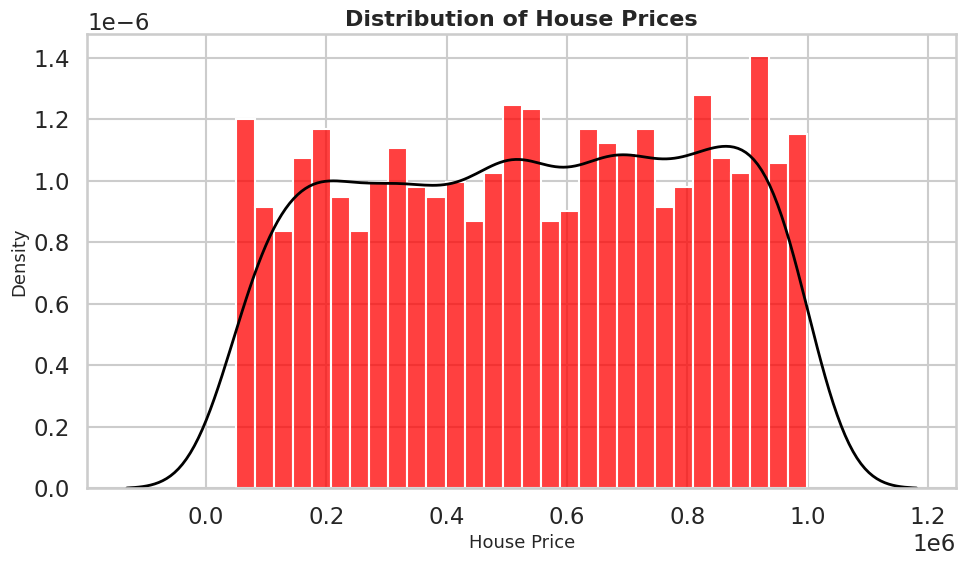

The correlation between Area and Price is: 0.15421203243642292 %
Price        1.000000
Floors       0.055890
YearBuilt    0.004845
Area         0.001542
Bedrooms    -0.003471
Bathrooms   -0.015737
Id          -0.025643
Name: Price, dtype: float64


In [ ]:
sns.set_theme(style="whitegrid", context="talk")

plt.figure(figsize=(10, 6))

# Histogram
sns.histplot(
    df["Price"],
    bins=30,
    stat="density",
    color="red",
    alpha=0.75,
    edgecolor="white"
)

# KDE (separate)
sns.kdeplot(
    df["Price"],
    color="black",
    linewidth=2
)

plt.title("Distribution of House Prices", fontsize=16, weight="bold")
plt.xlabel("House Price", fontsize=13)
plt.ylabel("Density", fontsize=13)

plt.tight_layout()
plt.show()

correlation = df['Area'].corr(df['Price']) * 100

print(f"The correlation between Area and Price is: {correlation} %")

# Computes correlation for all numerical columns
corr_matrix = df.corr(numeric_only=True)

# Display just the Price column to see what impacts price most
print(corr_matrix['Price'].sort_values(ascending=False))

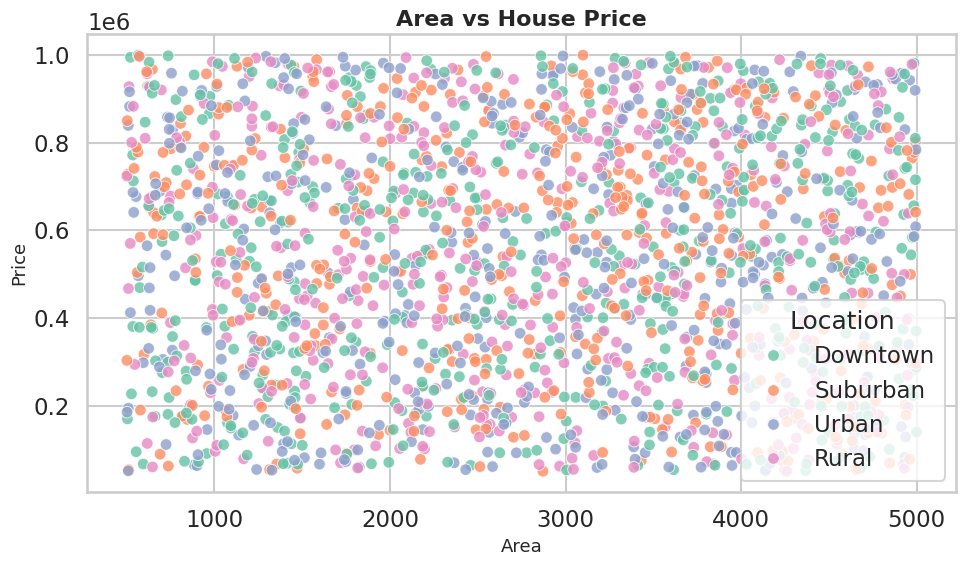

In [ ]:
sns.set_theme(style="whitegrid", context="talk")

plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=df,
    x="Area",
    y="Price",
    hue="Location",   # categorical column
    palette="Set2",
    s=70,
    alpha=0.8
)


plt.xlabel("Area", fontsize=13)
plt.ylabel("Price", fontsize=13)
plt.title("Area vs House Price", fontsize=16, weight="bold")

plt.tight_layout()
plt.show()


/tmp/ipython-input-3611358756.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Area', y='Price', data=df, palette='Set2')


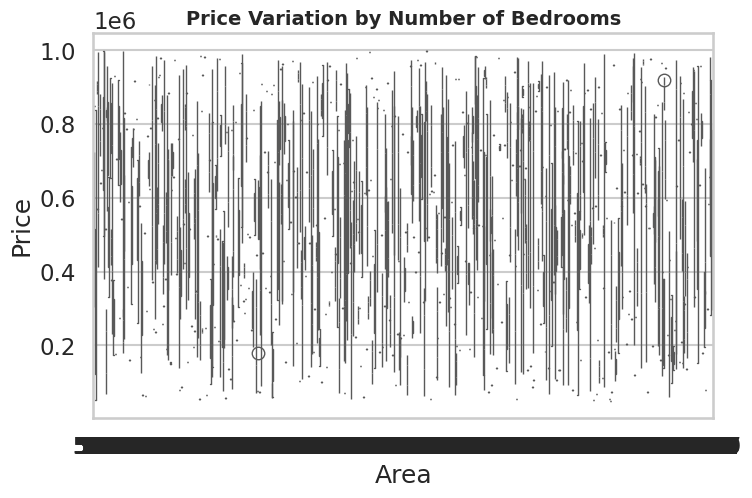

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Area', y='Price', data=df, palette='Set2')
plt.title("Price Variation by Number of Bedrooms", fontsize=14, weight='bold')
plt.show()

In [ ]:
X = df[['Area']]
Y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=2)

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R-squared: {r2:.4f}")

MAE: 242749.71
RMSE: 279897.49
R-squared: -0.0049
